In this notebook, the groups that are made (Metadata/group_cells_annotation.csv) will be evaluated. <br>
Also, data will be selected to model upon

In [1]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")
import AtlasAnalysisFunctions as AAF

In [2]:
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep = ";")

nsaf = pd.read_csv("../PEMatrix/norm_NSAF_data.csv", index_col="assay_id")

meta = meta[meta.assay_id.isin(nsaf.index)]
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])

In [3]:
meta.groupby("Group").cell_line.unique()

Group
CRC                                  [HCT116, Colo-205, KM12, SW527, HT29, CRC]
DOV13                                                                   [DOV13]
Ductal_breast                 [MCF7, ZR751, SKBR3, MDA-MB-231, MDA-MB-453, M...
HCC                                                      [Hep3B, MHCC97, HepG2]
HEK293                                                                 [HEK293]
HGSOC                         [TYKNU, KURAMOCHI, SNU119, TYKNUCP, 59M, CAOV3...
HUVEC                                                                   [HUVEC]
HeLa                                                                     [HeLa]
IOSE397                                                               [IOSE397]
IOSE7576                                                             [IOSE7576]
Lung                                                           [NCI-H460, A549]
Lymphoid_leukemia                                     [Jurkat, CCRF-CEM, JVM13]
MCF10F                            

The data is log transformed and median corrected as shown in 'preprocessing/Abundance_correction.ipynb' <br>
Now, the data will be minmaxed and the nan values imputed with 0

/home/compomics/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

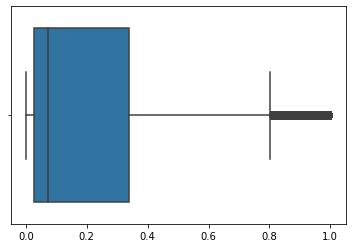

In [24]:
sns.boxplot(nsaf.notna().sum() / 557)

In [6]:
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf.fillna(0), .8)

In [7]:
nsaf_reoccurring = nsaf.loc[:,reoccuring]

/home/compomics/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

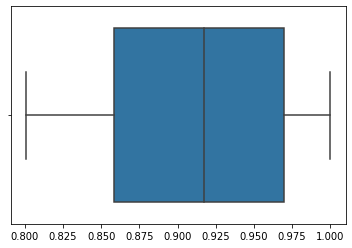

In [33]:
sns.boxplot(nsaf_reoccurring.notna().sum() / 557)

In [36]:
nsaf_reoccurring.iloc[:5,:]

,A0AVT1,A0MZ66,A5YKK6,A6NDG6,O00148,O00151,O00154,O00170,O00178,O00186,...,Q9Y5Z4,Q9Y617,Q9Y678,Q9Y679,Q9Y696,Q9Y6C9,Q9Y6D9,Q9Y6I3,Q9Y6W5,Q9Y6Y8
assay_id,,,,,,,,,,,,,,,,,,,,,
30960,0.613897,0.076670,-0.197381,0.198204,0.791668,1.131825,-0.177974,0.855464,-0.620286,-0.876618,...,-0.283705,2.039412,0.981484,-0.211253,1.012356,1.735103,-0.263036,-1.218830,-1.575003,-0.444672
30961,0.550970,0.034614,-0.260472,0.233340,0.702648,1.268363,-0.204487,0.803759,-0.640863,-0.861444,...,-0.134241,2.017639,1.046231,-0.272774,1.056477,1.621640,-0.134867,-1.062674,-1.554831,-0.592779
31008,0.281545,-0.165186,-0.151379,-0.157544,0.342356,1.320851,0.158273,0.587453,-1.129619,-0.080425,...,0.481209,1.209146,0.885251,-0.343894,1.300323,1.295667,-0.537579,-0.713636,-1.234510,-0.405641
31009,0.329751,-0.274676,-0.217067,-0.318788,0.150615,1.110199,0.152715,0.539565,-1.203992,-0.017598,...,0.437494,1.102338,0.981271,-0.446054,1.110489,1.270620,-0.513519,-0.674737,-0.993225,-0.586350
31102,NaN,NaN,0.263750,NaN,-0.245165,NaN,-0.978473,-0.873122,-1.400844,NaN,...,NaN,0.076657,-0.565232,-0.214827,0.527139,0.011009,0.265827,NaN,NaN,-1.701016


In [3]:
from sklearn.preprocessing import MinMaxScaler

## **Reasoning behind the preprocessing steps**

### Step 1: NSAF and median scaling
First, it was important to scale the protein expressions equally for each sample. You do not expect the expressions to all be a bit lower or higher. If this is the case, this most probably is caused by technical bias and thus needs to be corrected. This is a well established need and clearly explained here for peptide normalization: https://statomics.github.io/PDA21/pda_quantification_preprocessing.html <br>
Indeed, by calculating NSAF a normalization was already applied. Yet, if we look at the protein expression distribution and the fold change distibution between samples, clear bias still persists (../preprocessing/Abundance_correction.ipynb). A decision was made to normalize by subtracting the mean and dividing by the std of the protein expression values of the reoccuring proteins. The reason why this is not done on all the expression values of the samples is the following: <br> <br> Some samples have quantified +7000 proteins, others +-1500. This is almost a 5 fold difference. Sample 1 (7000 proteins) have identified more proteins because the MS-analysis was more in depth, thus allowing to detect a lot more lowly abundant proteins. This means the distribution of protein expression is different in a biologically logical sense. However, both samples should have identified the more highly abundant proteins such as histones, ribosome associated proteins and others. 1650 proteins in total were chosen based on the occurence in 70% or more of all samples. The reasoning is similar to using one protein marker such as DJ-1 (or in our analysis Q7KZF4) which is very stable in expression as a reference protein for protein abundance http://europepmc.org/article/MED/25225357 <br>
With this workflow, we hope to have applied a robust normalization method that is unbiased.

## Step 2: MinMax Scaling of the features
The reasoning for a minmax normalization of the features is as follows.<br><br>
We need to impute values for the missing protein expressions. The safest method is to impute 0 expression because it was unidentified. We cannot do this if the expression values are log scaled, as this would mean imputing expression 1. We also cannot first impute 0 and then logscale, as this would transform the values to -inf which is not desired for obvious reasons. Therefor, the log transformed expression values are first mapped in a range between 0 and 1, where 0 is the lowest identified expression value. Non-expressed proteins are imputed as 0 and thus receive the expression value of the lowest identified expression for that protein. <br><br>

One problem persists. By doing a minmax normalization, the stable protein expressions are spread out equally as the very variable protein expressions. However, due to the random nature in the former, we hope the ML model will ignore these features...

In [46]:
minmax = MinMaxScaler()
mm_nsaf = minmax.fit_transform(nsaf)
mm_nsaf = pd.DataFrame(mm_nsaf, index=nsaf.index, columns=nsaf.columns)

/home/compomics/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/compomics/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [40]:
exp_mm_nsaf = minmax.fit_transform(np.exp2(nsaf).fillna(0))
exp_mm_nsaf = pd.DataFrame(exp_mm_nsaf, index=nsaf.index, columns=nsaf.columns)

<AxesSubplot:ylabel='Density'>

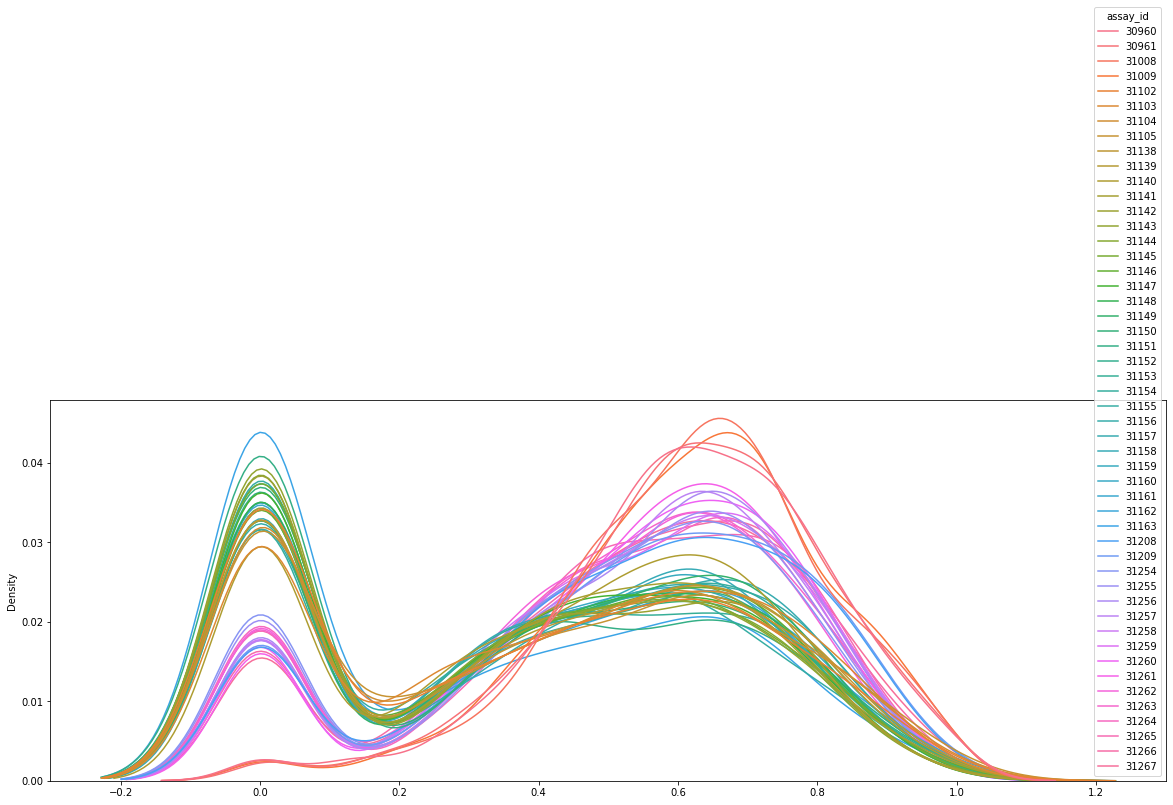

In [48]:
plt.figure(figsize=(20,7))
sns.kdeplot(data=mm_nsaf.fillna(0).loc[:,reoccuring].iloc[:50,:].transpose())

<AxesSubplot:ylabel='Density'>

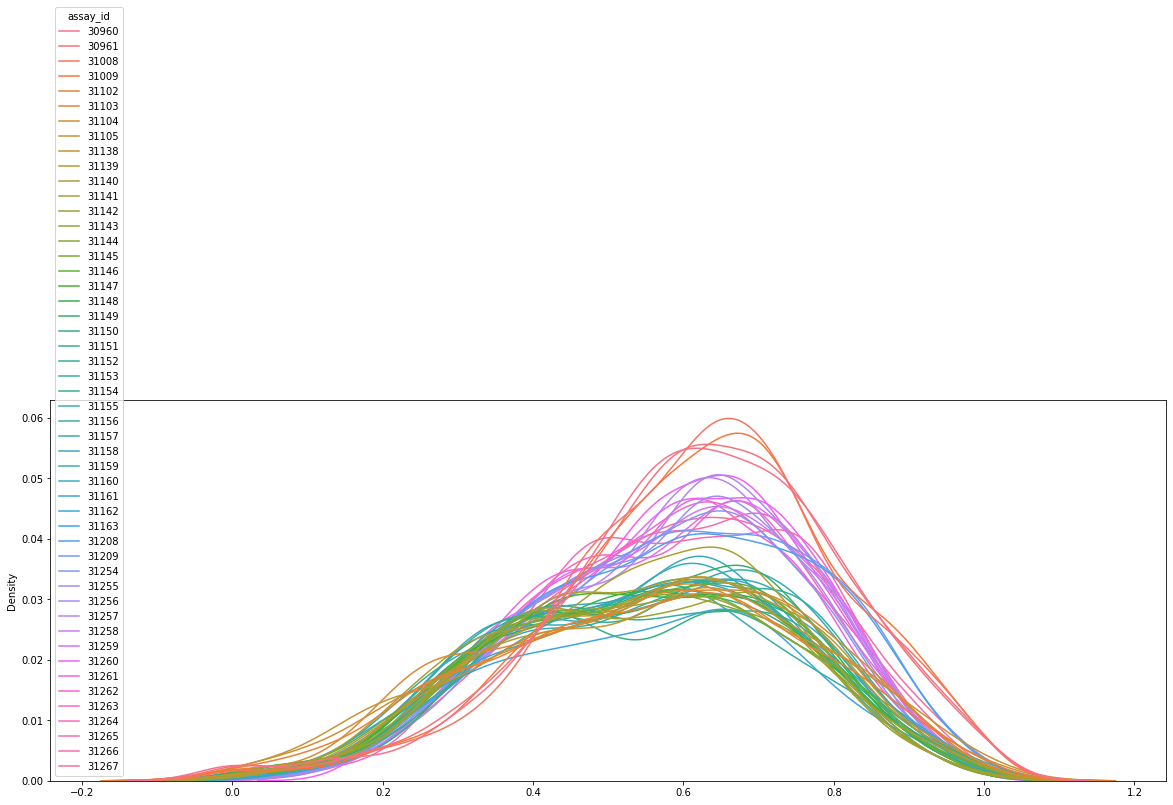

In [49]:
plt.figure(figsize=(20,7))
sns.kdeplot(data=mm_nsaf.loc[:,reoccuring].iloc[:50,:].transpose())

<AxesSubplot:ylabel='Density'>

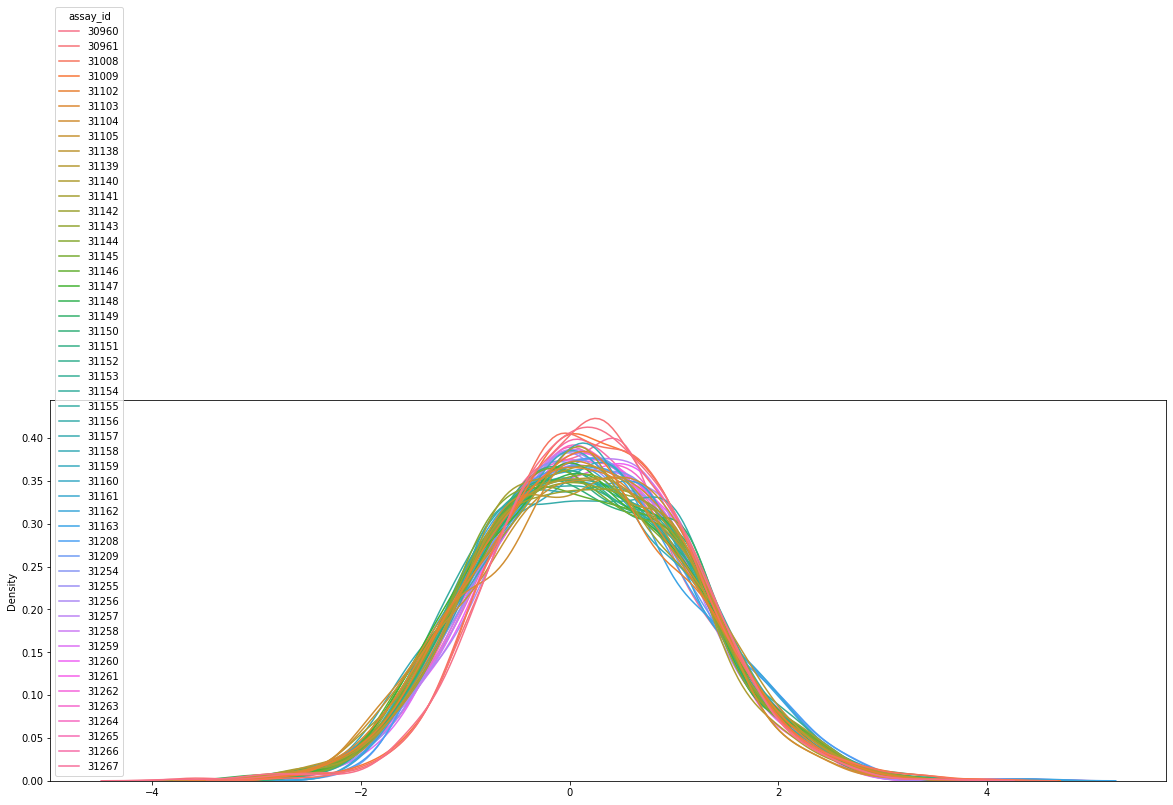

In [50]:
plt.figure(figsize=(20,7))
sns.kdeplot(data=nsaf.loc[:,reoccuring].iloc[:50,:].transpose(), common_norm=False)

In [12]:
preprocessed_nsaf = mm_nsaf
preprocessed_nsaf.to_csv("../PEMatrix/preprocessed_nsaf.csv")

Refilter so each class contains => 10 datapoints

In [55]:
apc = meta.Group.value_counts(sort = True)
apc=apc[apc>=10]
apc

Ductal_breast                 100
CRC                            78
HeLa                           60
Neuroblastoma                  48
HGSOC                          42
OV_endometrioid                26
SCC                            26
glioblastoma                   24
HUVEC                          24
Myeloid_leukemia               23
iPSC                           19
HEK293                         15
HCC                            13
ovarian_cystadenocarcinoma     10
Lymphoid_leukemia              10
Name: Group, dtype: int64

In [58]:
meta = meta[meta.Group.isin(apc.index)]
data = nsaf[nsaf.index.isin(meta.assay_id)]